# Mongodb scratchpad

Sam Maurer, October 2018

Make sure to launch the mongodb server first:  
`mongod --dbpath ~/mongodb-data`

https://api.mongodb.com/python/current/api/pymongo/index.html  
https://docs.mongodb.com/manual/reference/operator/aggregation-pipeline/

In [1]:
import numpy as np
import pandas as pd
import pymongo

import datetime
import os

In [2]:
%matplotlib inline

In [3]:
print(np.__version__)
print(pd.__version__)
print(pymongo.__version__)

1.15.2
0.23.4
3.7.1


### Mongo connection

In [4]:
client = pymongo.MongoClient()

In [5]:
print(client.server_info()['version'])

4.0.3


In [6]:
db = client.tweets
col = db.westcoastmonthly
r1 = db.westcoast_monthly_random_10k
r2 = db.westcoast_monthly_random_1M

In [4]:
col.count_documents({})

18000000

### Mongo operations

In [5]:
col.find_one({})

{'_id': ObjectId('5bc7b5dc6bbd390c66cde84e'),
 'contributors': None,
 'truncated': False,
 'text': "I can't click on digital representations of video clips any more. 🔪📼🖱🚨",
 'is_quote_status': False,
 'in_reply_to_status_id': None,
 'id': 738194571331391489,
 'favorite_count': 0,
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'retweeted': False,
 'coordinates': None,
 'timestamp_ms': '1464834275454',
 'entities': {'user_mentions': [], 'symbols': [], 'hashtags': [], 'urls': []},
 'in_reply_to_screen_name': None,
 'id_str': '738194571331391489',
 'retweet_count': 0,
 'in_reply_to_user_id': None,
 'favorited': False,
 'user': {'follow_request_sent': None,
  'profile_use_background_image': True,
  'default_profile_image': False,
  'id': 18794420,
  'verified': False,
  'profile_image_url_https': 'https://pbs.twimg.com/profile_images/569268765926240256/_t9_8eIa_normal.png',
  'profile_sidebar_fill_color': '000000',
  'profile_text_color': '

In [25]:
%%time
c = col.aggregate([{"$group": {"_id": {"lang": "$lang"}, "count": {"$sum": 1}}}])
for doc in c:
    print(doc)

{'_id': {'lang': 'hr'}, 'count': 63}
{'_id': {'lang': 'sk'}, 'count': 136}
{'_id': {'lang': 'ca'}, 'count': 288}
{'_id': {'lang': 'lo'}, 'count': 5}
{'_id': {'lang': 'or'}, 'count': 94}
{'_id': {'lang': 'am'}, 'count': 57}
{'_id': {'lang': 'te'}, 'count': 9}
{'_id': {'lang': 'ml'}, 'count': 2}
{'_id': {'lang': 'kn'}, 'count': 42}
{'_id': {'lang': 'sd'}, 'count': 1}
{'_id': {'lang': 'bn'}, 'count': 14}
{'_id': {'lang': 'my'}, 'count': 12}
{'_id': {'lang': 'mr'}, 'count': 4}
{'_id': {'lang': 'hy'}, 'count': 25}
{'_id': {'lang': 'el'}, 'count': 72}
{'_id': {'lang': 'ta'}, 'count': 59}
{'_id': {'lang': 'pl'}, 'count': 6241}
{'_id': {'lang': 'sr'}, 'count': 76}
{'_id': {'lang': 'ne'}, 'count': 99}
{'_id': {'lang': 'nl'}, 'count': 8601}
{'_id': {'lang': 'ur'}, 'count': 408}
{'_id': {'lang': 'ko'}, 'count': 5390}
{'_id': {'lang': 'lt'}, 'count': 1935}
{'_id': {'lang': 'zh'}, 'count': 5304}
{'_id': {'lang': 'bg'}, 'count': 187}
{'_id': {'lang': 'is'}, 'count': 2048}
{'_id': {'lang': 'hu'}, 'co

In [56]:
%%time
c = list(col.aggregate([{"$sortByCount": "$lang"}, {"$limit": 10}]))

CPU times: user 48.9 ms, sys: 16.5 ms, total: 65.4 ms
Wall time: 4min


In [59]:
total = col.estimated_document_count()

for doc in c:
    print("{}: {} ({}%)".format(doc['_id'], doc['count'], round(100*doc['count']/total, 1)))

en: 15367971 (85.4%)
und: 1515231 (8.4%)
es: 397040 (2.2%)
tl: 116017 (0.6%)
fr: 69486 (0.4%)
pt: 60277 (0.3%)
in: 56202 (0.3%)
ja: 54375 (0.3%)
ht: 47763 (0.3%)
ar: 40893 (0.2%)


In [6]:
%%time
c = list(col.aggregate([
    {"$sample": {"size": 1000}}, 
    {"$sortByCount": "$lang"}, 
    {"$limit": 10}]))
print(c)

[{'_id': 'en', 'count': 846}, {'_id': 'und', 'count': 101}, {'_id': 'es', 'count': 19}, {'_id': 'tl', 'count': 8}, {'_id': 'ht', 'count': 7}, {'_id': 'pt', 'count': 4}, {'_id': 'ja', 'count': 3}, {'_id': 'ar', 'count': 2}, {'_id': 'it', 'count': 2}, {'_id': 'in', 'count': 2}]
CPU times: user 2.06 ms, sys: 1.26 ms, total: 3.32 ms
Wall time: 5.93 s


In [11]:
%%time
c = list(col.aggregate([
    {"$sample": {"size": 10000}}, 
    {"$out": "westcoast_monthly_random_10k"}]))
print(c)

[]
CPU times: user 2.08 ms, sys: 2.34 ms, total: 4.42 ms
Wall time: 3.6 s


In [15]:
db.list_collection_names()

['westcoastmonthly',
 'westcoast_monthly_random_10k',
 'westcoast_sample_random_10k']

In [16]:
db.drop_collection('westcoast_sample_random_10k')

{'ns': 'tweets.westcoast_sample_random_10k', 'nIndexesWas': 1, 'ok': 1.0}

In [39]:
%%time
c = list(col.aggregate([
    {"$sample": {"size": 1000000}}, 
    {"$out": "westcoast_monthly_random_1M"}],
    allowDiskUse = True))
print(c)

[]
CPU times: user 398 ms, sys: 133 ms, total: 531 ms
Wall time: 17min 57s


In [6]:
%%time
c = list(r1.aggregate([
    {"$sortByCount": "$lang"}, 
    {"$limit": 10}]))
print(c)

[{'_id': 'en', 'count': 8510}, {'_id': 'und', 'count': 832}, {'_id': 'es', 'count': 240}, {'_id': 'tl', 'count': 70}, {'_id': 'fr', 'count': 43}, {'_id': 'in', 'count': 35}, {'_id': 'pt', 'count': 31}, {'_id': 'ht', 'count': 28}, {'_id': 'ja', 'count': 27}, {'_id': 'ar', 'count': 26}]
CPU times: user 1.16 ms, sys: 900 µs, total: 2.06 ms
Wall time: 126 ms


In [7]:
%%time
c = list(r1.aggregate([
    {"$project": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$sortByCount": {"$year": "$_dt"}}]))
print(c)

[{'_id': 2016, 'count': 3396}, {'_id': 2017, 'count': 3304}, {'_id': 2018, 'count': 2573}, {'_id': 2015, 'count': 727}]
CPU times: user 1.47 ms, sys: 1.35 ms, total: 2.82 ms
Wall time: 39.6 ms


In [26]:
%%time
c = list(r1.aggregate([
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$limit": 1},
    {"$project": {"_dt": True}}]))
print(c)

[{'_id': ObjectId('5bc7c1a26bbd390c6672acd1'), '_dt': datetime.datetime(2016, 10, 2, 3, 14, 5, 255000)}]
CPU times: user 2.45 ms, sys: 1.19 ms, total: 3.64 ms
Wall time: 18.7 ms


In [8]:
%%time
c = list(r2.aggregate([
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "count": {"$sum": 1}}}]))
print(c[:2])

[{'_id': {'y': None, 'm': None}, 'count': 10}, {'_id': {'y': 2018, 'm': 2}, 'count': 27907}]
CPU times: user 5.06 ms, sys: 2.03 ms, total: 7.1 ms
Wall time: 18.7 s


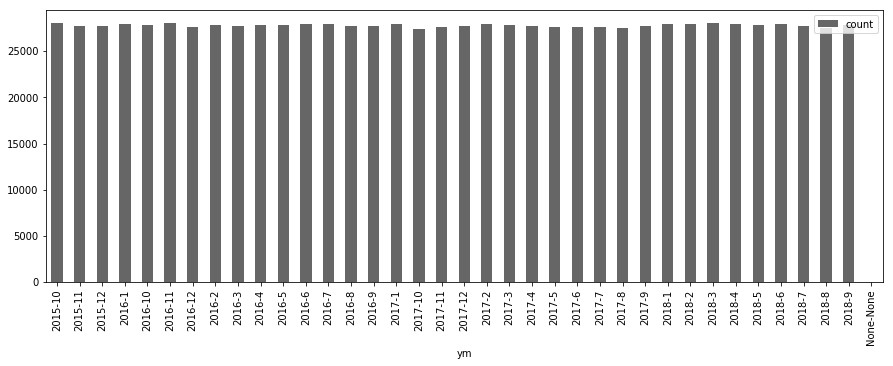

In [11]:
ym, count = ([], [])

for doc in c:
    ym.append(str(doc['_id']['y']) + '-' + str(doc['_id']['m']))
    count.append(doc['count'])

df = pd.DataFrame({'ym': ym, 'count': count}).sort_values('ym')
df.plot.bar(x='ym', y='count', figsize=(15,5), facecolor='666')

In [9]:
calif_bbox = {'type':'Polygon','coordinates': [[[-124.48, 42.01], [-124.48, 32.52],
[-114.13, 32.52], [-114.13, 42.01], [-124.48, 42.01]]]}

In [16]:
%%time
print(collection.count_documents({"coordinates": {"$geoWithin": {"$geometry": calif_bbox}}}))

504604
CPU times: user 5.42 ms, sys: 3.06 ms, total: 8.48 ms
Wall time: 24.4 s


In [17]:
%%time
c = list(r2.aggregate([
    {"$sortByCount": "$source"}, 
    {"$limit": 20}]))

for doc in c:
    print(doc['_id'].split('>')[1].split('<')[0] + ': ' + str(doc['count']))

Twitter for iPhone: 624704
Twitter for Android: 138688
Twitter Web Client: 81734
Instagram: 63172
TweetMyJOBS: 30618
Tweetbot for iΟS: 9456
Twitter for iPad: 8298
Foursquare: 7559
SafeTweet by TweetMyJOBS: 3931
Cities: 3334
Tweetbot for Mac: 2546
CareerArc 2.0: 2242
GeoScrubApp: 2030
Untappd: 1767
Zorrotron: 1731
Collatron: 1101
City of Portland 911 feed: 1049
dlvr.it: 999
Spot Reporters Server: 968
Sandaysoft Cumulus: 947
CPU times: user 3.17 ms, sys: 1.66 ms, total: 4.83 ms
Wall time: 4.21 s


In [33]:
%%time
c = list(r2.aggregate([
    {"$match": {"source": {"$regex" : ".*>Twitter .*"}}},
    {"$sortByCount": "$source"}, 
    {"$limit": 10}]))

for doc in c:
    print(doc['_id'].split('>')[1].split('<')[0] + ': ' + str(doc['count']))

Twitter for iPhone: 624704
Twitter for Android: 138688
Twitter Web Client: 81734
Twitter for iPad: 8298
Twitter for  iPhone: 421
Twitter for Windows Phone: 223
Twitter for Android Tablets: 166
Twitter for Mac: 33
Twitter Dashboard for iPhone: 29
Twitter for BlackBerry: 26
CPU times: user 1.68 ms, sys: 1.2 ms, total: 2.88 ms
Wall time: 2.38 s


### Plotting function

In [9]:
def plot_counts(c):
    ym, count = ([], [])

    for doc in c:
        ym.append(str(doc['_id']['y']) + '-' + str(doc['_id']['m']).zfill(2))
        count.append(doc['count'])

    df = pd.DataFrame({'ym': ym, 'count': count}).sort_values('ym')
    df.plot.bar(x='ym', y='count', figsize=(15,5), facecolor='666')

CPU times: user 48.1 ms, sys: 2 ms, total: 50.1 ms
Wall time: 4.25 s


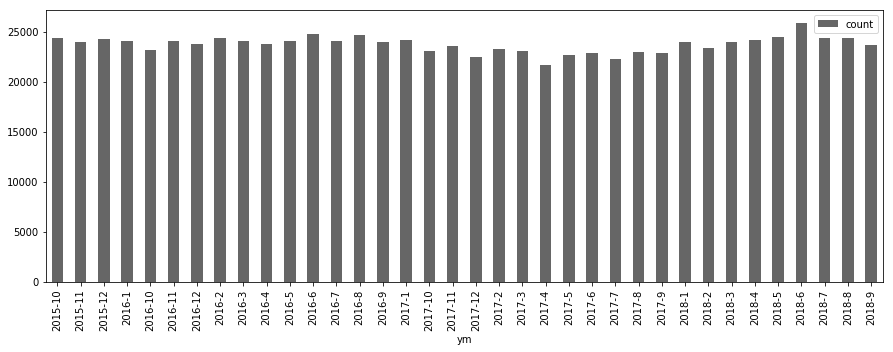

In [39]:
%%time
c = list(r2.aggregate([
    {"$match": {"source": {"$regex" : ".*>Twitter .*"}}},
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "count": {"$sum": 1}}}]))
plot_counts(c)

CPU times: user 48.5 ms, sys: 1.91 ms, total: 50.4 ms
Wall time: 1.89 s


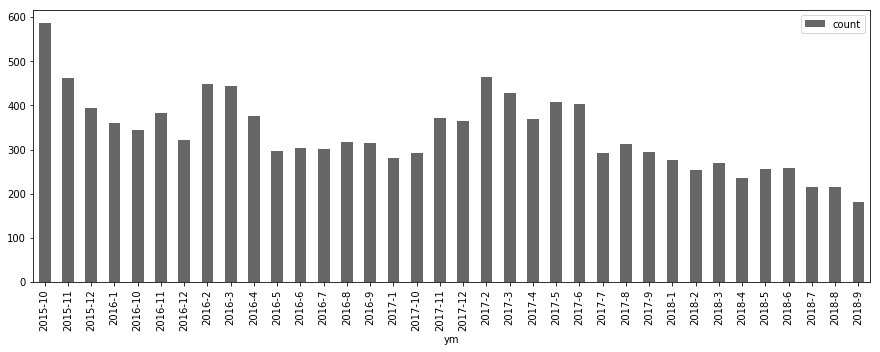

In [40]:
%%time
c = list(r2.aggregate([
    {"$match": {"source": {"$regex" : ".*>Tweetbot .*"}}},
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "count": {"$sum": 1}}}]))
plot_counts(c)

CPU times: user 46.7 ms, sys: 2.15 ms, total: 48.9 ms
Wall time: 2.01 s


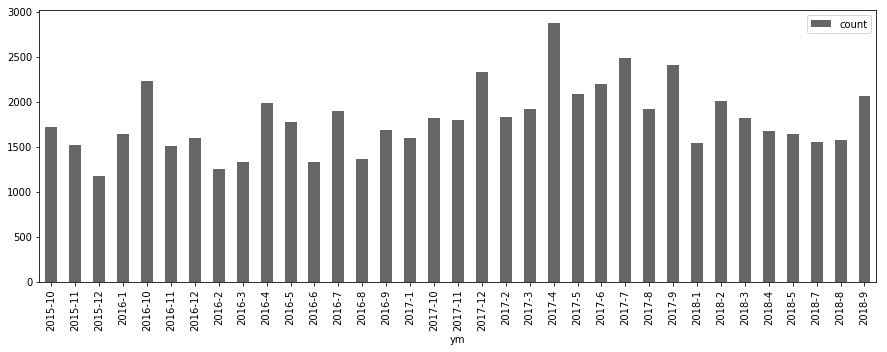

In [41]:
%%time
c = list(r2.aggregate([
    {"$match": {"source": {"$regex" : ".*>Instagram<.*"}}},
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "count": {"$sum": 1}}}]))
plot_counts(c)

CPU times: user 50.8 ms, sys: 1.89 ms, total: 52.6 ms
Wall time: 1.83 s


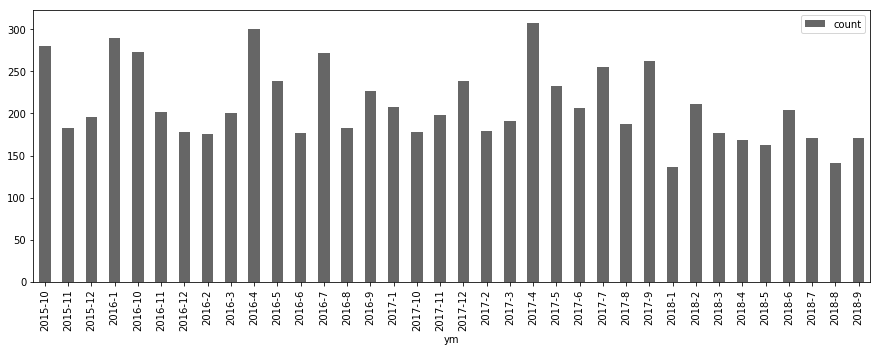

In [42]:
%%time
c = list(r2.aggregate([
    {"$match": {"source": {"$regex" : ".*>Foursquare<.*"}}},
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "count": {"$sum": 1}}}]))
plot_counts(c)

In [49]:
%%time
c = list(r2.aggregate([
    {"$project": {"coordinates": True}}, 
    {"$limit": 20}]))

for doc in c:
    print(doc['coordinates'])

None
None
None
{'type': 'Point', 'coordinates': [-122.67, 45.63]}
None
None
{'type': 'Point', 'coordinates': [-122.705, 38.4486]}
None
None
None
{'type': 'Point', 'coordinates': [-122.7144314, 38.4404674]}
None
None
None
{'type': 'Point', 'coordinates': [-113.583, 37.1042]}
None
None
None
{'type': 'Point', 'coordinates': [-122.236, 38.113]}
None
CPU times: user 2.4 ms, sys: 1.4 ms, total: 3.79 ms
Wall time: 31.6 ms


In [50]:
%%time
c = list(r2.aggregate([
    {"$project": {"geo": True}}, 
    {"$limit": 20}]))

for doc in c:
    print(doc['geo'])

None
None
None
{'type': 'Point', 'coordinates': [45.63, -122.67]}
None
None
{'type': 'Point', 'coordinates': [38.4486, -122.705]}
None
None
None
{'type': 'Point', 'coordinates': [38.4404674, -122.7144314]}
None
None
None
{'type': 'Point', 'coordinates': [37.1042, -113.583]}
None
None
None
{'type': 'Point', 'coordinates': [38.113, -122.236]}
None
CPU times: user 2.36 ms, sys: 1.52 ms, total: 3.88 ms
Wall time: 38.3 ms


In [52]:
%%time
c = list(r2.aggregate([
    {"$project": {"place": True}}, 
    {"$limit": 10}]))

for doc in c:
    print(doc['place'])

{'full_name': 'Culver City, CA', 'url': 'https://api.twitter.com/1.1/geo/id/a75bc1fb166cd594.json', 'country': 'United States', 'place_type': 'city', 'bounding_box': {'type': 'Polygon', 'coordinates': [[[-118.448451, 33.976882], [-118.448451, 34.035143], [-118.369529, 34.035143], [-118.369529, 33.976882]]]}, 'country_code': 'US', 'attributes': {}, 'id': 'a75bc1fb166cd594', 'name': 'Culver City'}
{'full_name': 'Los Angeles, CA', 'url': 'https://api.twitter.com/1.1/geo/id/3b77caf94bfc81fe.json', 'country': 'United States', 'place_type': 'city', 'bounding_box': {'type': 'Polygon', 'coordinates': [[[-118.668404, 33.704538], [-118.668404, 34.337041], [-118.155409, 34.337041], [-118.155409, 33.704538]]]}, 'country_code': 'US', 'attributes': {}, 'id': '3b77caf94bfc81fe', 'name': 'Los Angeles'}
{'full_name': 'San Francisco, CA', 'url': 'https://api.twitter.com/1.1/geo/id/5a110d312052166f.json', 'country': 'United States', 'place_type': 'city', 'bounding_box': {'type': 'Polygon', 'coordinates':

CPU times: user 48.3 ms, sys: 2.82 ms, total: 51.1 ms
Wall time: 1.09 s


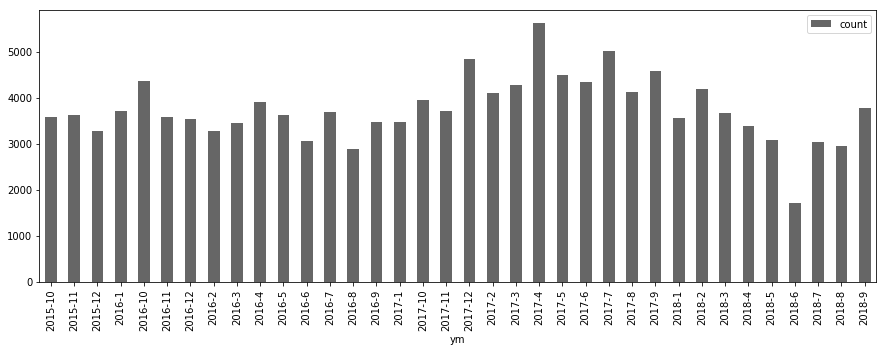

In [54]:
%%time
c = list(r2.aggregate([
    {"$match": {"coordinates": {"$ne": None}}},
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "count": {"$sum": 1}}}]))
plot_counts(c)

CPU times: user 48.2 ms, sys: 1.7 ms, total: 49.9 ms
Wall time: 1.32 s


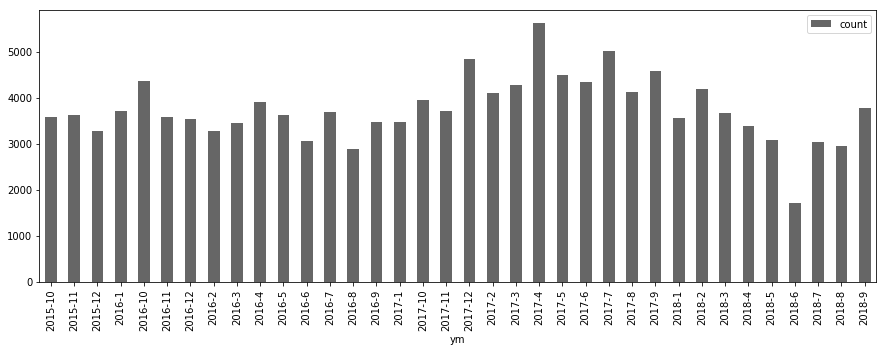

In [55]:
%%time
c = list(r2.aggregate([
    {"$match": {"geo": {"$ne": None}}},
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "count": {"$sum": 1}}}]))
plot_counts(c)

CPU times: user 53.3 ms, sys: 1.4 ms, total: 54.7 ms
Wall time: 3.72 s


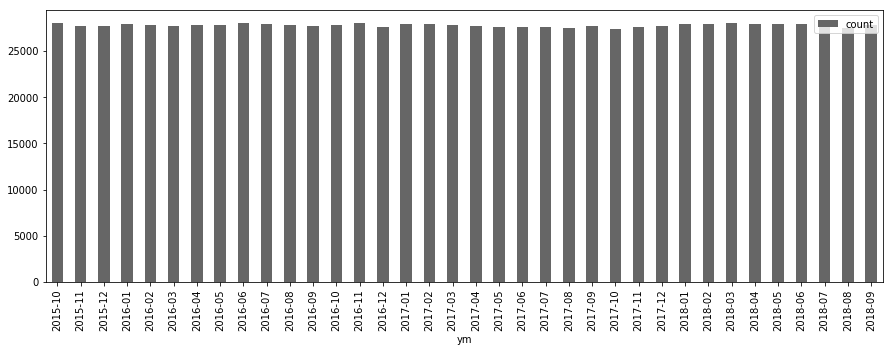

In [24]:
%%time
c = list(r2.aggregate([
    {"$match": {"place": {"$ne": None}}},
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "count": {"$sum": 1}}}]))
plot_counts(c)

In [7]:
%%time
c = list(r2.aggregate([
    {"$match": {"geo": {"$ne": None}}},
    {"$sortByCount": "$source"}, 
    {"$limit": 20}]))

for doc in c:
    print(doc['_id'].split('>')[1].split('<')[0] + ': ' + str(doc['count']))

Instagram: 63172
TweetMyJOBS: 30618
Foursquare: 7559
SafeTweet by TweetMyJOBS: 3931
Cities: 3334
CareerArc 2.0: 2242
Untappd: 1767
Zorrotron: 1731
Twitter for Android: 1651
Twitter for iPhone: 1198
Collatron: 1101
City of Portland 911 feed: 1049
Tweetbot for iΟS: 1033
dlvr.it: 999
Spot Reporters Server: 968
Sandaysoft Cumulus: 947
dlvr.it: 705
TownTweet: 631
City of Portland Fire/EMS feed: 541
Virtual Jukebox - Recent Tracks: 479
CPU times: user 1.76 ms, sys: 1.68 ms, total: 3.43 ms
Wall time: 953 ms


In [60]:
%%time
c = list(r2.aggregate([
    {"$sortByCount": "$place.place_type"}, 
    {"$limit": 20}]))

for doc in c:
    print(str(doc['_id']) + ': ' + str(doc['count']))

city: 890263
admin: 82006
poi: 11933
country: 9050
neighborhood: 6480
None: 268
CPU times: user 1.44 ms, sys: 1.1 ms, total: 2.54 ms
Wall time: 1.84 s


In [61]:
%%time
c = list(r2.aggregate([
    {"$sortByCount": "$place.full_name"}, 
    {"$limit": 20}]))

for doc in c:
    print(str(doc['_id']) + ': ' + str(doc['count']))

Los Angeles, CA: 122937
California, USA: 39821
San Francisco, CA: 30833
San Diego, CA: 30217
Seattle, WA: 21500
Portland, OR: 17389
Las Vegas, NV: 16973
San Jose, CA: 15690
Paradise, NV: 14110
Arizona, USA: 12555
Long Beach, CA: 11088
Calgary, Alberta: 10935
Oakland, CA: 10924
Vancouver, British Columbia: 9690
Sacramento, CA: 9400
Fresno, CA: 8858
Anaheim, CA: 8527
Bakersfield, CA: 7608
Washington, USA: 7555
Riverside, CA: 6794
CPU times: user 1.9 ms, sys: 1.36 ms, total: 3.26 ms
Wall time: 2.1 s


In [37]:
%%time
c = list(r2.aggregate([
    {"$match": {"place.place_type": "poi"}},
    {"$sortByCount": "$place.full_name"}, 
    {"$limit": 20}]))

for doc in c:
    print(str(doc['_id']) + ': ' + str(doc['count']))

Twitter HQ: 559
Los Angeles International Airport (LAX): 79
Dodger Stadium: 72
Disneyland: 71
San Francisco International Airport (SFO): 59
STAPLES Center: 59
Petco Park: 49
Safeco Field: 49
Rose Bowl Stadium: 41
Rattlesnake Bar Folsom Lake: 38
San Diego Convention Center: 38
Starbucks: 37
Disney California Adventure Park: 35
Venice Beach: 35
Anaheim Convention Center: 34
The Forum: 32
Oracle Arena: 32
24 Hour Fitness: 30
Universal Studios Hollywood: 30
The Hollywood Bowl: 29
CPU times: user 1.98 ms, sys: 1.42 ms, total: 3.41 ms
Wall time: 1.05 s


CPU times: user 53.6 ms, sys: 1.71 ms, total: 55.3 ms
Wall time: 1.8 s


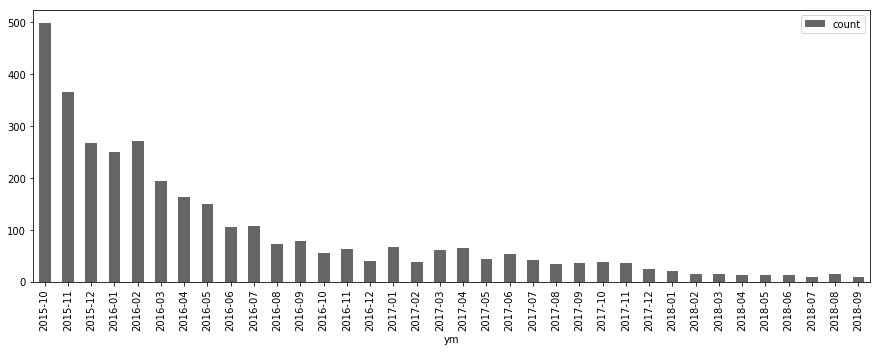

In [10]:
%%time
c = list(r2.aggregate([
    {"$match": {"$and": [{"geo": {"$ne": None}}, {"source": {"$regex" : ".*>Twitter .*"}}]}},
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "count": {"$sum": 1}}}]))
plot_counts(c)

CPU times: user 54.2 ms, sys: 1.66 ms, total: 55.9 ms
Wall time: 2.14 s


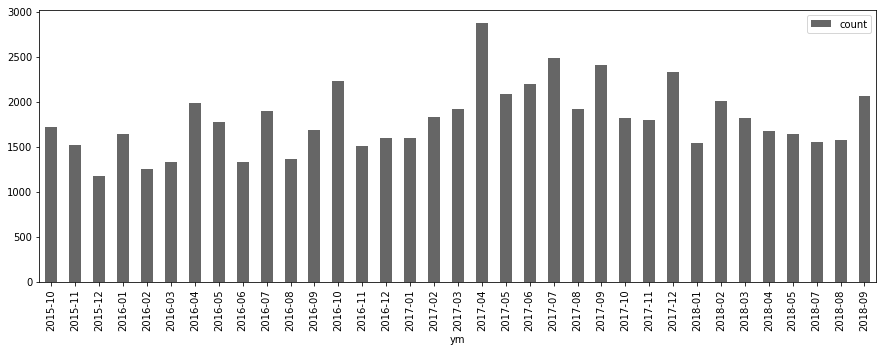

In [11]:
%%time
c = list(r2.aggregate([
    {"$match": {"$and": [{"geo": {"$ne": None}}, {"source": {"$regex" : ".*>Instagram<.*"}}]}},
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "count": {"$sum": 1}}}]))
plot_counts(c)

So coordinate tags in general are staying about level, but they're mostly not from the Twitter app -- not that very many of them were initially either

CPU times: user 91.2 ms, sys: 1.16 ms, total: 92.3 ms
Wall time: 2.19 s


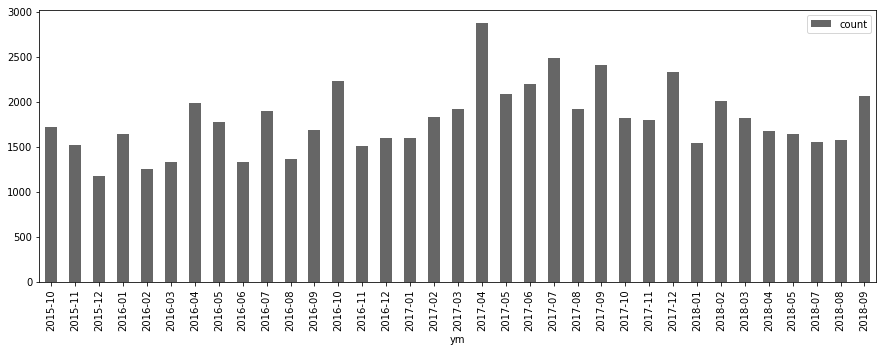

In [12]:
%%time
c = list(r2.aggregate([
    {"$match": {"source": {"$regex" : ".*>Instagram<.*"}}},
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "count": {"$sum": 1}}}]))
plot_counts(c)

In [14]:
%%time
c = list(r2.aggregate([
    {"$match": {"source": {"$regex" : ".*>Instagram<.*"}}},
    {"$sortByCount": "$coordinates.coordinates"}, 
    {"$limit": 10}]))

for doc in c:
    print(str(doc['_id']) + ': ' + str(doc['count']))

[-118.243, 34.0522]: 2915
[-115.136, 36.175]: 600
[-122.418, 37.775]: 442
[-117.156, 32.7153]: 361
[-122.331, 47.6064]: 318
[-123.1, 49.25]: 281
[-122.682, 45.52]: 249
[-117.9188776, 33.81224332]: 236
[-118.481, 34.0221]: 215
[-114.057, 51.045]: 202
CPU times: user 1.75 ms, sys: 1.22 ms, total: 2.97 ms
Wall time: 2.1 s


In [15]:
%%time
c = list(r2.aggregate([
    {"$match": {"source": {"$regex" : ".*>Twitter .*"}}},
    {"$sortByCount": "$coordinates.coordinates"}, 
    {"$limit": 20}]))

for doc in c:
    print(str(doc['_id']) + ': ' + str(doc['count']))

None: 850974
[-118.3077924, 34.2630117]: 8
[-121.4569108, 38.5454871]: 6
[-119.7980592, 36.9424373]: 5
[-119.7967611, 36.9414986]: 4
[-121.7175745, 42.2033757]: 4
[-118.09663486, 34.09195995]: 4
[-118.3751849, 34.0551246]: 4
[-116.5901365, 43.5847311]: 4
[-119.7042428, 36.8045926]: 3
[-121.4568661, 38.5454633]: 3
[-114.9239775, 32.5159586]: 3
[-118.2150024, 34.0473923]: 3
[-119.7897503, 36.7436139]: 3
[-123.1408188, 49.2865504]: 3
[-118.2462749, 33.7584201]: 3
[-118.1835304, 33.8545302]: 3
[-122.9169598, 49.1991832]: 3
[-122.4082498, 45.5204213]: 3
[-119.7980311, 36.9423351]: 3
CPU times: user 2.32 ms, sys: 1.35 ms, total: 3.66 ms
Wall time: 2.1 s


And the Instagram points look like centroids of polygons, while the Twitter ones aren't (top one is in LA)

In [25]:
%%time
c = list(r2.aggregate([
    {"$match": {"source": {"$regex" : ".*>Instagram<.*"}}},
    {"$sortByCount": "$place.place_type"}, 
    {"$limit": 20}]))

for doc in c:
    print(str(doc['_id']) + ': ' + str(doc['count']))

city: 56702
admin: 6364
neighborhood: 94
None: 10
country: 2
CPU times: user 1.61 ms, sys: 1.23 ms, total: 2.83 ms
Wall time: 2.02 s


In [26]:
%%time
c = list(r2.aggregate([
    {"$match": {"source": {"$regex" : ".*>Foursquare<.*"}}},
    {"$sortByCount": "$place.place_type"}, 
    {"$limit": 20}]))

for doc in c:
    print(str(doc['_id']) + ': ' + str(doc['count']))

city: 7000
admin: 555
neighborhood: 4
CPU times: user 1.51 ms, sys: 1.11 ms, total: 2.62 ms
Wall time: 1.9 s


In [27]:
%%time
c = list(r2.aggregate([
    {"$match": {"$and": [{"geo": {"$ne": None}}, {"source": {"$regex" : ".*>Twitter .*"}}]}},
    {"$sortByCount": "$place.place_type"}, 
    {"$limit": 20}]))

for doc in c:
    print(str(doc['_id']) + ': ' + str(doc['count']))

city: 2966
admin: 246
poi: 98
neighborhood: 26
country: 25
CPU times: user 1.54 ms, sys: 1.11 ms, total: 2.65 ms
Wall time: 1.74 s


CPU times: user 58 ms, sys: 1.9 ms, total: 59.9 ms
Wall time: 3.33 s


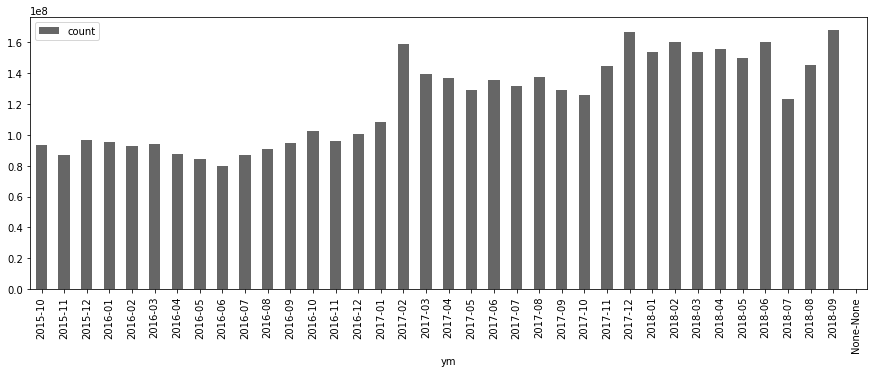

In [35]:
%%time
c = list(r2.aggregate([
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "maxTimestamp": {"$max": "$_dt"},
                "minTimestamp": {"$min": "$_dt"}}},
    {"$addFields": {"count": {"$subtract": ["$maxTimestamp", "$minTimestamp"]}}}]))
plot_counts(c)